# Assignment 3

In [64]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix

## Task 1

** Description **

Train 4 different classifiers: decision tree (small + deep), random forest (with small base estimators and deep)

**Read data**

In [2]:
df = pd.read_csv("../data/bioresponse.csv")
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


**Create test-train split**

In [6]:
y = df["Activity"]
X = df.drop(columns=["Activity"])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, shuffle=True, test_size=0.25)

In [15]:
def train(clf: callable, params: dict, X=X_train, y=y_train):
    m = clf(**params)
    m.fit(X, y)
    return m

### Decision tree (small)

In [20]:
tree_small_params = {
    "max_depth": 5
}
tree_small = train(DecisionTreeClassifier, tree_small_params)

### Decision tree (deep)

In [21]:
tree_deep_params = {
}
tree_deep = train(DecisionTreeClassifier, tree_deep_params)

### Random forest with small trees

In [23]:
rf_small_params = {
    "max_depth": 5
}
rf_small = train(RandomForestClassifier, rf_small_params)

### Random forest with deep trees

In [24]:
rf_deep_params = {
}
rf_deep = train(RandomForestClassifier, rf_deep_params)

## Task 2

**Description**

Calculate precision, recall, accuracy, f1 score and log-loss for each model

In [29]:
def evaluate(model, X=X_test, y=y_test):
    y_pred = model.predict(X)

    print(classification_report(y, y_pred))
    print(f"Log-loss: {log_loss(y, y_pred)}")

    plot_roc_curve(model, X, y)
    plot_precision_recall_curve(model, X, y)

### Decision tree (small)

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       413
           1       0.80      0.79      0.80       525

    accuracy                           0.77       938
   macro avg       0.77      0.77      0.77       938
weighted avg       0.77      0.77      0.77       938

Log-loss: 7.843116556339175


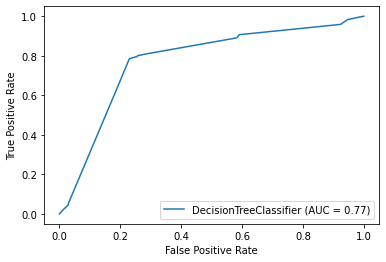

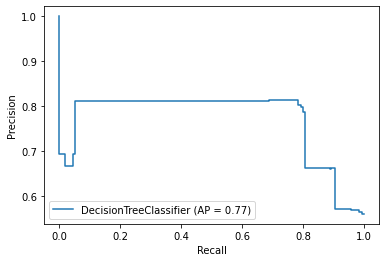

In [30]:
evaluate(tree_small)

### Decision tree (deep)

              precision    recall  f1-score   support

           0       0.68      0.69      0.69       413
           1       0.75      0.74      0.75       525

    accuracy                           0.72       938
   macro avg       0.72      0.72      0.72       938
weighted avg       0.72      0.72      0.72       938

Log-loss: 9.647400601212862


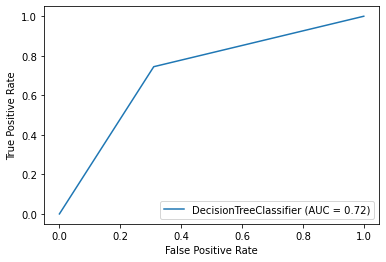

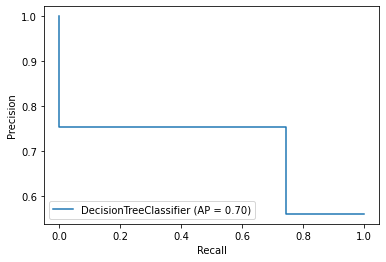

In [31]:
evaluate(tree_deep)

### Random forest (small)

              precision    recall  f1-score   support

           0       0.68      0.77      0.72       413
           1       0.80      0.71      0.75       525

    accuracy                           0.74       938
   macro avg       0.74      0.74      0.74       938
weighted avg       0.74      0.74      0.74       938

Log-loss: 9.095047474303025


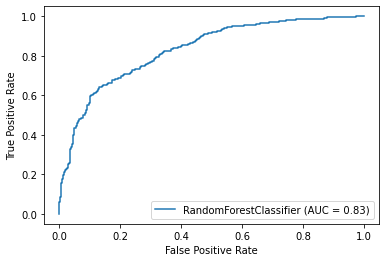

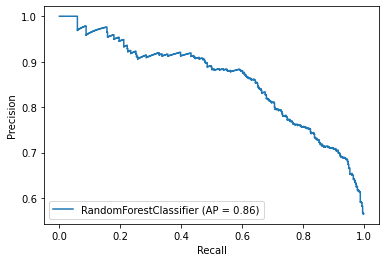

In [32]:
evaluate(rf_small)

### Random forest (deep)

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       413
           1       0.84      0.81      0.83       525

    accuracy                           0.81       938
   macro avg       0.81      0.81      0.81       938
weighted avg       0.81      0.81      0.81       938

Log-loss: 6.627980083233687


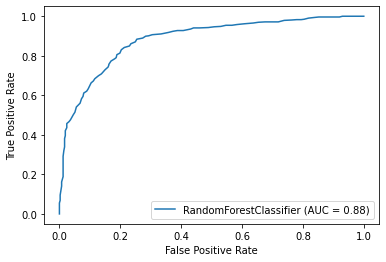

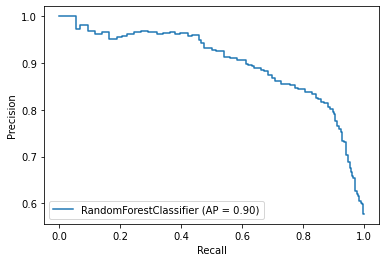

In [33]:
evaluate(rf_deep)

**Conclusion**

As expected from theory deep decision tree classifers overfit as they build trees up to one element in every leaf. This doesn't generalize well, which is clearnly shown with significantly simpler model with depth=5 showing better results. 

Random forests on the other hand works better with deep decision trees as best estimators, because we need low bias and the variance will be taken care of by the ensemble of many such trees. In practice, however, reasonably deep (say 10-15) trees already work good and are a lot faster in both training and inference

### Task 4

**Description**

Train a classifier that reduces FN, evaluate it

In [55]:
class ThresholdedWrapper(RandomForestClassifier):

    def predict(self, X):
        y_pred_proba = self.predict_proba(X)
        y_pred = (y_pred_proba[:, 1] >= self.threshold).astype(np.int8)

        return y_pred

In [59]:
avoids_fn = ThresholdedWrapper()
avoids_fn.fit(X_train, y_train)

ThresholdedWrapper()

In [ ]:
avoids_fn.threshold = 0.05
y_pred = avoids_fn.predict(X_test)

confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))
print(f"Log-loss: {log_loss(y_test, y_pred)}")

Threshold here is selected in such a way to completely remove FN on the given test set, such extremes are probably not very usefull and do not give any guarantees about presence of FN errors on other splits.

In [77]:
Threshold here is selected in such a way to completely remove FN on the given test set, such extremes are probably not very usefull and do not give any guarantees about presence of FN errors on other splits.

array([[ 10, 403],
       [  0, 525]])

In [81]:
print(classification_report(y_test, y_pred))
print(f"Log-loss: {log_loss(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       1.00      0.02      0.05       413
           1       0.57      1.00      0.72       525

    accuracy                           0.57       938
   macro avg       0.78      0.51      0.38       938
weighted avg       0.76      0.57      0.43       938

Log-loss: 14.839498000973746


Threshold here is selected in such a way to completely remove FN on the given test set, such extremes are probably not very usefull and do not give any guarantees about presence of FN errors on other splits.